# 2018-05-18 - MP et reconnaissance d'angles
On va intégrer l'isolation d'edges progressif avec la bibliothèque SparseEdges et la classif d'angles extraits avec les réseaux qu'on a déjà utilisés.

Ca mime un peu les saccades et permet de faire une reconstruction angles à angles de l'image et plus un traitement global ou un traitement basé sur l'entropy, un peu lourd et pas super réaliste.

# A part d'edge pre-computed (mp.run_mp)

In [1]:
from SparseEdges import SparseEdges
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N = 2048
mp.pe.MP_alpha=1.
mp.pe.figpath, name = './mp', 'mpnaturalimage'

image = mp.imread('tiger.jpg')
mp.init()
image = mp.normalize(image, center=True)

In [ ]:
edges, C_res = mp.run_mp(image, verbose=True)

In [ ]:
import pickle
pickle.dump(edges, open('edges.p', 'wb'))

In [2]:
import pickle
edges = pickle.load( open('edges.p', 'rb'))

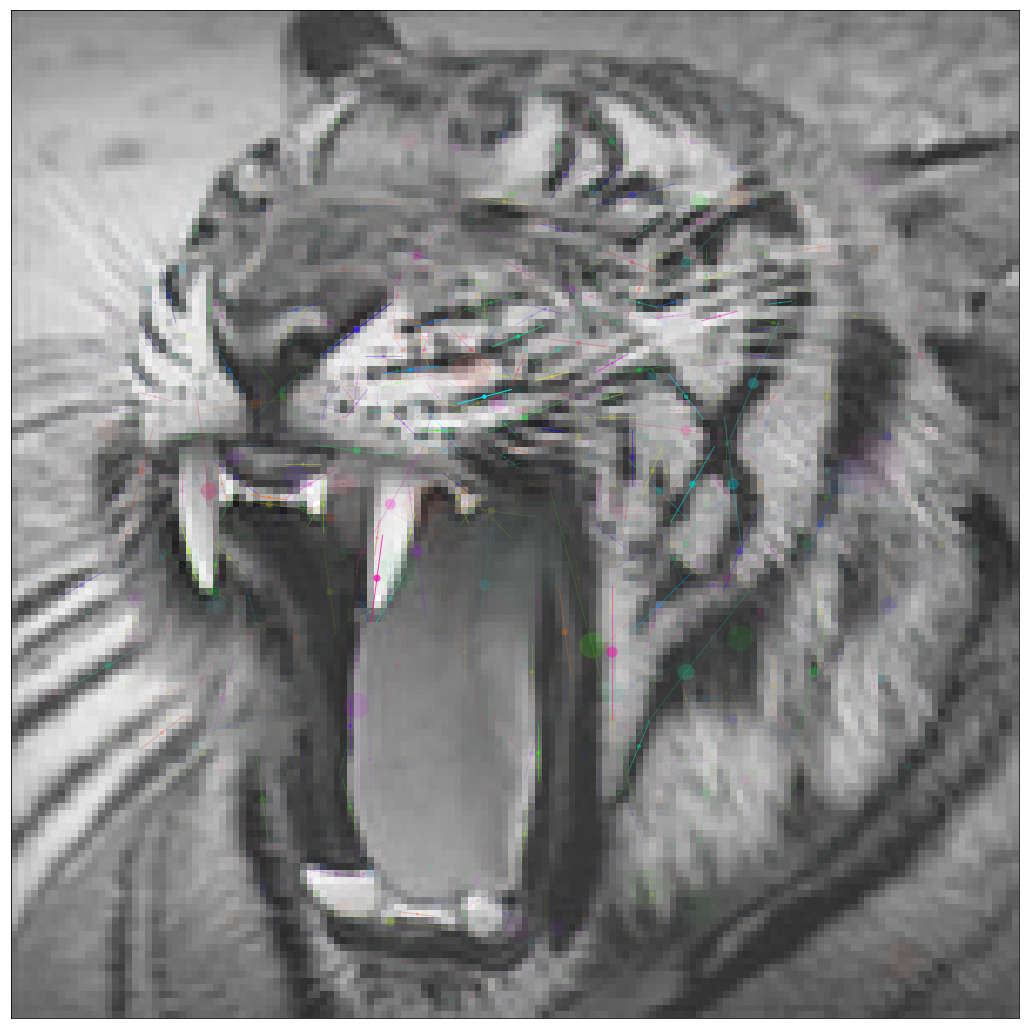

In [3]:
fig, a = mp.show_edges(edges, image=image)

On extrait une série d'edge qu'on va ensuite classifier :

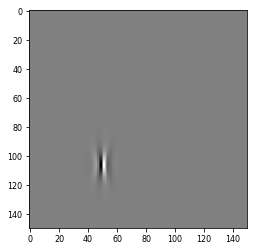

In [4]:
from torchvision import transforms, datasets
from PIL import Image
import numpy as np
from torch.autograd import Variable

edges_list = np.linspace(1,25,25)

fig_width = 14
vmax = 1.
vmax = image.max()

image_rec_list = []

transformations = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])

for i_ax, number_of_edge in enumerate(edges_list):
    number_of_edge = int(number_of_edge)
    
    edges_ = edges[:, number_of_edge-1:number_of_edge][..., np.newaxis]
    
    image_rec = mp.dewhitening(mp.reconstruct(edges_))
    image_plot = image_rec #save them unchanged for latter plotting purposes
    
    plt.imshow(image_rec, cmap = 'gray')

    image_rec = Image.fromarray((image_rec*255).astype('uint8'))

    image_rec = transformations(image_rec)
    image_rec = Variable(image_rec)
    image_rec_list.append((image_rec, image_plot)) 

On défini et entraine le réseau LSTM de la veille sur des MC :

In [11]:
"""
Created on Tue May 15 11:25:41 2018

@author: hugo
"""
from torch.autograd import Variable
import torch 
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets

#Transform
data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

#Train
train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=16, shuffle=True,
                                             num_workers=1)

#Test
test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=16,shuffle=True,
                                             num_workers=1)

# Hyper-parameters
sequence_length = 64
input_size = 64
hidden_size = 128
num_layers = 2
num_classes = 16
batch_size = 16
num_epochs = 20
learning_rate = 0.003

class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)  # 2 for bidirection
    
    def forward(self, x):
        # Init
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size) # 2 for bidirection 
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
        h0 = Variable(h0)
        c0 = Variable(c0)
        h0 = h0.cuda()
        c0 = c0.cuda()

        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size*2)
        
        # LSTM output
        out = self.fc(out[:, -1, :])
        return out

model = BiRNN(input_size, hidden_size, num_layers, num_classes)
model = model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#plotting list
loss_list = []
time_list = []
t = 0

print("Start training")
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.view(-1, sequence_length, input_size))
        labels = Variable(labels)
        images = images.cuda()
        labels = labels.cuda()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.data[0]))
            loss_list.append(loss.data[0])
            time_list.append(t)
            t+=1

Start training
Epoch [1/20], Step [100/240], Loss: 2.7579
Epoch [1/20], Step [200/240], Loss: 2.4815
Epoch [2/20], Step [100/240], Loss: 2.4581
Epoch [2/20], Step [200/240], Loss: 2.7438
Epoch [3/20], Step [100/240], Loss: 2.1788
Epoch [3/20], Step [200/240], Loss: 1.8375
Epoch [4/20], Step [100/240], Loss: 1.3064
Epoch [4/20], Step [200/240], Loss: 1.2630
Epoch [5/20], Step [100/240], Loss: 1.2589
Epoch [5/20], Step [200/240], Loss: 1.2442
Epoch [6/20], Step [100/240], Loss: 1.0857
Epoch [6/20], Step [200/240], Loss: 0.7806
Epoch [7/20], Step [100/240], Loss: 0.6413
Epoch [7/20], Step [200/240], Loss: 0.4523
Epoch [8/20], Step [100/240], Loss: 0.8416
Epoch [8/20], Step [200/240], Loss: 0.1814
Epoch [9/20], Step [100/240], Loss: 0.3739
Epoch [9/20], Step [200/240], Loss: 0.2032
Epoch [10/20], Step [100/240], Loss: 0.0787
Epoch [10/20], Step [200/240], Loss: 0.2217
Epoch [11/20], Step [100/240], Loss: 0.1695
Epoch [11/20], Step [200/240], Loss: 0.2517
Epoch [12/20], Step [100/240], Loss

In [12]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, sequence_length, input_size))
    labels = Variable(labels)
    images = images.cuda()
    labels = labels.cuda()
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).sum()

print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 

Test Accuracy of the model on the 10000 test images: 92 %


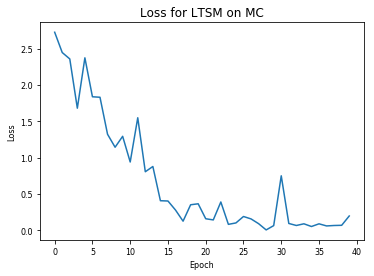

In [7]:
#joli plot du loss en fonction de l'epoch
import matplotlib.pyplot as plt
plt.plot(time_list, loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss for LTSM on MC')
plt.show()

On loop a travers les edges générés précédemment et on les classifie :

In [13]:
output_list = []

for i, (edge, img) in enumerate(image_rec_list):
    edge_to_classify = image_rec_list[i][0]
    edge_to_classify = Variable(edge_to_classify.view(-1, sequence_length, input_size)).cuda() #wrap in Variable
    
    output = model(edge_to_classify)
    output = output.cpu() #cuda fucks up argmax for some reason
    output_list.append((output.data.numpy().argmax()
                        ,image_rec_list[i][1])) #append prediction and edge image for plotting

Et on affiche l'edge avec le MC associé (c'est pas toujours glorieux) :

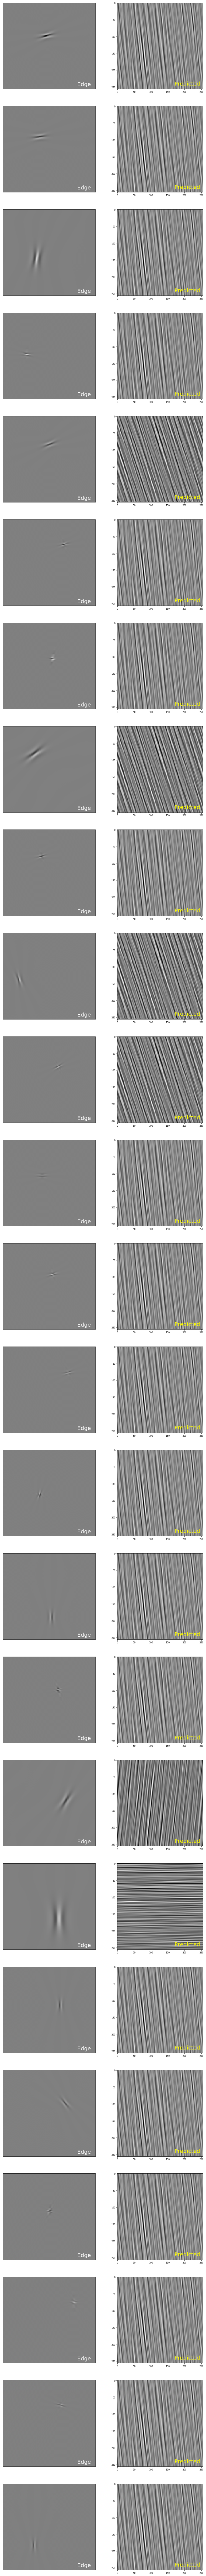

In [15]:
import os

subfolders = sorted(os.listdir("16_clouds_easy"))
fig_width = 14
fig, axs = plt.subplots(len(output_list), 2,figsize=(fig_width, fig_width/2*len(output_list)))

for i, tup in enumerate(output_list) :
    
    fig, axs[i, 0] = mp.imshow((output_list[i][1]),
                               fig=fig, ax=axs[i, 0], norm=False) #edge
    axs[i, 0].text(120, 144, 'Edge', color='white', fontsize=20) #text indicating edge
    
    #opens a motionCloud to display, from the subfolder of the predicted label (output_list[i][0])
    #and does a secondlistdir to get the first image from that subfolder (it's a bit hairy really)
    MC_to_display = Image.open('./16_clouds_easy/%s/%s' % (subfolders[output_list[i][0]],
                                                          os.listdir("16_clouds_easy/%s" % subfolders[output_list[i][0]])[0]))
    #MC_to_display = np.asarray(MC_to_display)
    axs[i,1].imshow(MC_to_display, cmap= 'gray')
    #fig, axs[i, 1] = mp.imshow((MC_to_display),fig=fig, ax=axs[i, 1], norm=False) #MC
    axs[i, 1].text(170, 245, 'Predicted', color='yellow', fontsize=20) #text indicating edge
    

# LinearNN ? Somewhat better

In [5]:
import torch
import torchvision
from torchvision import transforms, datasets

data_transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

train_set = datasets.ImageFolder(root='16_clouds_easy',
                                transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set,
                                             batch_size=4, shuffle=True,
                                             num_workers=1)

test_set = datasets.ImageFolder(root='16_clouds_easy_test',
                                transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=4,shuffle=False,
                                             num_workers=1)


from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(64 * 64, 200)
            self.fc2 = nn.Linear(200, 200)
            self.fc3 = nn.Linear(200, 16)

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            return F.log_softmax(input=x)
model = Net().cuda()
print(model)

import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

import time
start_time = time.time()
print("Started training")

epochs = 50
print_interval = 50 #prints every p_i*4
tempo = []
acc = []

for epoch in range(epochs):  # nbr epochs
    for batch_idx, (data, target) in enumerate(train_loader): #nbr batch,in,out
        data, target = Variable(data).cuda(), Variable(target).cuda()
        
        #On resize pour la sortie
        data = data.view(-1, 64*64)

        #init l'entrainement
        optimizer.zero_grad()
        net_out = model(data)

        loss = criterion(net_out, target)
        loss.backward()
        optimizer.step()

        #afficher la progression
        if batch_idx % print_interval == 0:
            #le print statement le plus illisible du monde
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.data[0]))
    tempo.append(epoch)
    acc.append(loss.data[0])
    
print("Finished training in  %.3f seconds " % (time.time() - start_time))

Net(
  (fc1): Linear(in_features=4096, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=16, bias=True)
)
Started training
Epoch: 1 [0/3840 (0%)]	Loss: 2.759939
Epoch: 1 [200/3840 (5%)]	Loss: 2.763170
Epoch: 1 [400/3840 (10%)]	Loss: 2.793400
Epoch: 1 [600/3840 (16%)]	Loss: 2.728404
Epoch: 1 [800/3840 (21%)]	Loss: 2.793770
Epoch: 1 [1000/3840 (26%)]	Loss: 2.766175
Epoch: 1 [1200/3840 (31%)]	Loss: 2.740100
Epoch: 1 [1400/3840 (36%)]	Loss: 2.777768
Epoch: 1 [1600/3840 (42%)]	Loss: 2.755165
Epoch: 1 [1800/3840 (47%)]	Loss: 2.688505
Epoch: 1 [2000/3840 (52%)]	Loss: 2.766933
Epoch: 1 [2200/3840 (57%)]	Loss: 2.851500
Epoch: 1 [2400/3840 (62%)]	Loss: 2.790720
Epoch: 1 [2600/3840 (68%)]	Loss: 2.800502
Epoch: 1 [2800/3840 (73%)]	Loss: 2.753719
Epoch: 1 [3000/3840 (78%)]	Loss: 2.832864
Epoch: 1 [3200/3840 (83%)]	Loss: 2.831594
Epoch: 1 [3400/3840 (89%)]	Loss: 2.859210
Epoch: 1 [3600/3840 (94%)]	Loss: 2.840652
E

Epoch: 10 [2400/3840 (62%)]	Loss: 0.002040
Epoch: 10 [2600/3840 (68%)]	Loss: 0.000032
Epoch: 10 [2800/3840 (73%)]	Loss: 0.000198
Epoch: 10 [3000/3840 (78%)]	Loss: 0.001652
Epoch: 10 [3200/3840 (83%)]	Loss: 0.000136
Epoch: 10 [3400/3840 (89%)]	Loss: 0.003166
Epoch: 10 [3600/3840 (94%)]	Loss: 0.002828
Epoch: 10 [3800/3840 (99%)]	Loss: 0.001588
Epoch: 11 [0/3840 (0%)]	Loss: 0.000727
Epoch: 11 [200/3840 (5%)]	Loss: 0.000853
Epoch: 11 [400/3840 (10%)]	Loss: 0.000056
Epoch: 11 [600/3840 (16%)]	Loss: 0.002118
Epoch: 11 [800/3840 (21%)]	Loss: 0.002178
Epoch: 11 [1000/3840 (26%)]	Loss: 0.000756
Epoch: 11 [1200/3840 (31%)]	Loss: 0.000191
Epoch: 11 [1400/3840 (36%)]	Loss: 0.000055
Epoch: 11 [1600/3840 (42%)]	Loss: 0.001360
Epoch: 11 [1800/3840 (47%)]	Loss: 0.001942
Epoch: 11 [2000/3840 (52%)]	Loss: 0.000270
Epoch: 11 [2200/3840 (57%)]	Loss: 0.000673
Epoch: 11 [2400/3840 (62%)]	Loss: 0.000050
Epoch: 11 [2600/3840 (68%)]	Loss: 0.000869
Epoch: 11 [2800/3840 (73%)]	Loss: 0.000390
Epoch: 11 [3000/3840

Epoch: 20 [1000/3840 (26%)]	Loss: 0.000247
Epoch: 20 [1200/3840 (31%)]	Loss: 0.000131
Epoch: 20 [1400/3840 (36%)]	Loss: 0.000161
Epoch: 20 [1600/3840 (42%)]	Loss: 0.002345
Epoch: 20 [1800/3840 (47%)]	Loss: 0.000556
Epoch: 20 [2000/3840 (52%)]	Loss: 0.000316
Epoch: 20 [2200/3840 (57%)]	Loss: 0.000551
Epoch: 20 [2400/3840 (62%)]	Loss: 0.000095
Epoch: 20 [2600/3840 (68%)]	Loss: 0.000291
Epoch: 20 [2800/3840 (73%)]	Loss: 0.000366
Epoch: 20 [3000/3840 (78%)]	Loss: 0.000031
Epoch: 20 [3200/3840 (83%)]	Loss: 0.000526
Epoch: 20 [3400/3840 (89%)]	Loss: 0.000079
Epoch: 20 [3600/3840 (94%)]	Loss: 0.000002
Epoch: 20 [3800/3840 (99%)]	Loss: 0.000422
Epoch: 21 [0/3840 (0%)]	Loss: 0.000659
Epoch: 21 [200/3840 (5%)]	Loss: 0.000164
Epoch: 21 [400/3840 (10%)]	Loss: 0.000667
Epoch: 21 [600/3840 (16%)]	Loss: 0.000197
Epoch: 21 [800/3840 (21%)]	Loss: 0.000005
Epoch: 21 [1000/3840 (26%)]	Loss: 0.000160
Epoch: 21 [1200/3840 (31%)]	Loss: 0.000710
Epoch: 21 [1400/3840 (36%)]	Loss: 0.000048
Epoch: 21 [1600/3840

Epoch: 29 [3600/3840 (94%)]	Loss: 0.000032
Epoch: 29 [3800/3840 (99%)]	Loss: 0.000044
Epoch: 30 [0/3840 (0%)]	Loss: 0.000011
Epoch: 30 [200/3840 (5%)]	Loss: 0.000236
Epoch: 30 [400/3840 (10%)]	Loss: 0.000117
Epoch: 30 [600/3840 (16%)]	Loss: 0.000268
Epoch: 30 [800/3840 (21%)]	Loss: 0.000108
Epoch: 30 [1000/3840 (26%)]	Loss: 0.000264
Epoch: 30 [1200/3840 (31%)]	Loss: 0.000037
Epoch: 30 [1400/3840 (36%)]	Loss: 0.000114
Epoch: 30 [1600/3840 (42%)]	Loss: 0.000073
Epoch: 30 [1800/3840 (47%)]	Loss: 0.000063
Epoch: 30 [2000/3840 (52%)]	Loss: 0.000075
Epoch: 30 [2200/3840 (57%)]	Loss: 0.000034
Epoch: 30 [2400/3840 (62%)]	Loss: 0.000119
Epoch: 30 [2600/3840 (68%)]	Loss: 0.000061
Epoch: 30 [2800/3840 (73%)]	Loss: 0.000166
Epoch: 30 [3000/3840 (78%)]	Loss: 0.000347
Epoch: 30 [3200/3840 (83%)]	Loss: 0.000210
Epoch: 30 [3400/3840 (89%)]	Loss: 0.000008
Epoch: 30 [3600/3840 (94%)]	Loss: 0.000018
Epoch: 30 [3800/3840 (99%)]	Loss: 0.000011
Epoch: 31 [0/3840 (0%)]	Loss: 0.000274
Epoch: 31 [200/3840 (5%)

Epoch: 39 [2200/3840 (57%)]	Loss: 0.000060
Epoch: 39 [2400/3840 (62%)]	Loss: 0.000128
Epoch: 39 [2600/3840 (68%)]	Loss: 0.000097
Epoch: 39 [2800/3840 (73%)]	Loss: 0.000046
Epoch: 39 [3000/3840 (78%)]	Loss: 0.000308
Epoch: 39 [3200/3840 (83%)]	Loss: 0.000058
Epoch: 39 [3400/3840 (89%)]	Loss: 0.000029
Epoch: 39 [3600/3840 (94%)]	Loss: 0.000061
Epoch: 39 [3800/3840 (99%)]	Loss: 0.000073
Epoch: 40 [0/3840 (0%)]	Loss: 0.000147
Epoch: 40 [200/3840 (5%)]	Loss: 0.000089
Epoch: 40 [400/3840 (10%)]	Loss: 0.000030
Epoch: 40 [600/3840 (16%)]	Loss: 0.000080
Epoch: 40 [800/3840 (21%)]	Loss: 0.000007
Epoch: 40 [1000/3840 (26%)]	Loss: 0.000029
Epoch: 40 [1200/3840 (31%)]	Loss: 0.000070
Epoch: 40 [1400/3840 (36%)]	Loss: 0.000103
Epoch: 40 [1600/3840 (42%)]	Loss: 0.000000
Epoch: 40 [1800/3840 (47%)]	Loss: 0.000017
Epoch: 40 [2000/3840 (52%)]	Loss: 0.000142
Epoch: 40 [2200/3840 (57%)]	Loss: 0.000001
Epoch: 40 [2400/3840 (62%)]	Loss: 0.000081
Epoch: 40 [2600/3840 (68%)]	Loss: 0.000008
Epoch: 40 [2800/3840

Epoch: 49 [800/3840 (21%)]	Loss: 0.000792
Epoch: 49 [1000/3840 (26%)]	Loss: 0.000081
Epoch: 49 [1200/3840 (31%)]	Loss: 0.000057
Epoch: 49 [1400/3840 (36%)]	Loss: 0.000004
Epoch: 49 [1600/3840 (42%)]	Loss: 0.000002
Epoch: 49 [1800/3840 (47%)]	Loss: 0.000019
Epoch: 49 [2000/3840 (52%)]	Loss: 0.000055
Epoch: 49 [2200/3840 (57%)]	Loss: 0.000064
Epoch: 49 [2400/3840 (62%)]	Loss: 0.000187
Epoch: 49 [2600/3840 (68%)]	Loss: 0.000066
Epoch: 49 [2800/3840 (73%)]	Loss: 0.000131
Epoch: 49 [3000/3840 (78%)]	Loss: 0.000062
Epoch: 49 [3200/3840 (83%)]	Loss: 0.000048
Epoch: 49 [3400/3840 (89%)]	Loss: 0.000196
Epoch: 49 [3600/3840 (94%)]	Loss: 0.000016
Epoch: 49 [3800/3840 (99%)]	Loss: 0.000116
Epoch: 50 [0/3840 (0%)]	Loss: 0.000134
Epoch: 50 [200/3840 (5%)]	Loss: 0.000077
Epoch: 50 [400/3840 (10%)]	Loss: 0.000077
Epoch: 50 [600/3840 (16%)]	Loss: 0.000041
Epoch: 50 [800/3840 (21%)]	Loss: 0.000109
Epoch: 50 [1000/3840 (26%)]	Loss: 0.000044
Epoch: 50 [1200/3840 (31%)]	Loss: 0.000065
Epoch: 50 [1400/3840 

In [14]:
test_loss = 0
correct = 0

for data, target in test_loader:
    data, target = Variable(data, volatile=True).cuda(), Variable(target).cuda()
    
    #rescale
    data = data.view(-1, 64 * 64)
    net_out = model(data)
    
    #somme des pertes du batch
    test_loss += criterion(net_out, target).data[0]
    pred = net_out.data.max(1)[1] #prediction
    correct += pred.eq(target.data).sum() #output du réseau

test_loss /= len(test_loader.dataset) #loss = loss/length set
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.3315, Accuracy: 410/576 (71%)



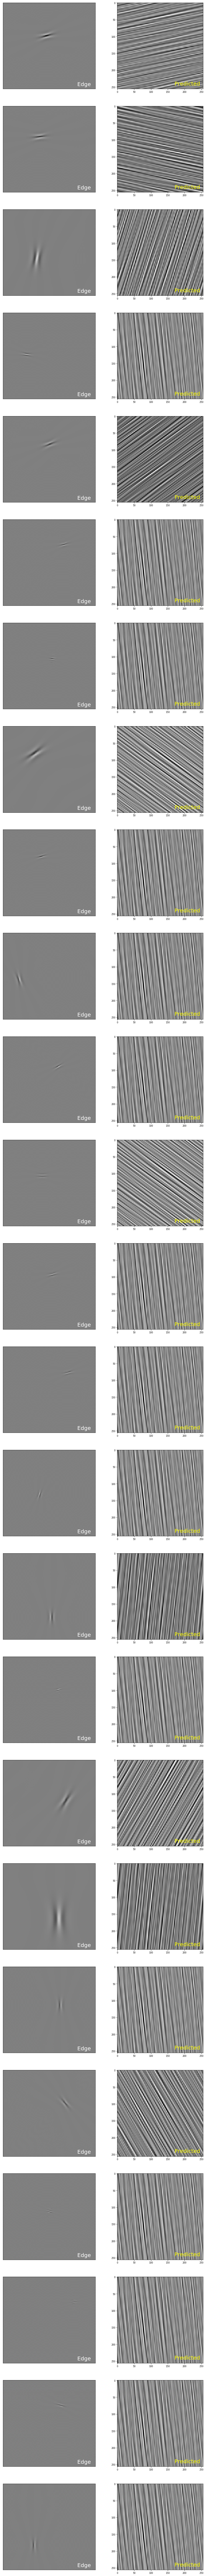

In [19]:
output_list = []

for i, (edge, img) in enumerate(image_rec_list):
    edge_to_classify = image_rec_list[i][0]
    edge_to_classify = Variable(edge_to_classify.view(-1,64*64)).cuda() #wrap in Variable
    
    output = model(edge_to_classify)
    output = output.cpu() #cuda fucks up argmax for some reason
    output_list.append((output.data.numpy().argmax()
                        ,image_rec_list[i][1])) #append prediction and edge image for plotting
    
    

import os

subfolders = sorted(os.listdir("16_clouds_easy"))
fig_width = 14
fig, axs = plt.subplots(len(output_list), 2,figsize=(fig_width, fig_width/2*len(output_list)))

for i, tup in enumerate(output_list) :
    
    fig, axs[i, 0] = mp.imshow((output_list[i][1]),
                               fig=fig, ax=axs[i, 0], norm=False) #edge
    axs[i, 0].text(120, 144, 'Edge', color='white', fontsize=20) #text indicating edge
    
    #opens a motionCloud to display, from the subfolder of the predicted label (output_list[i][0])
    #and does a secondlistdir to get the first image from that subfolder (it's a bit hairy really)
    MC_to_display = Image.open('./16_clouds_easy/%s/%s' % (subfolders[output_list[i][0]],
                                                          os.listdir("16_clouds_easy/%s" % subfolders[output_list[i][0]])[0]))
    #MC_to_display = np.asarray(MC_to_display)
    axs[i,1].imshow(MC_to_display, cmap= 'gray')
    #fig, axs[i, 1] = mp.imshow((MC_to_display),fig=fig, ax=axs[i, 1], norm=False) #MC
    axs[i, 1].text(170, 245, 'Predicted', color='yellow', fontsize=20) #text indicating edge
    

# MP for only first edges 

In [18]:
from SparseEdges import SparseEdges
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os

mp = SparseEdges('https://raw.githubusercontent.com/bicv/SparseEdges/master/default_param.py')
mp.pe.N = 4
mp.pe.do_mask=False
mp.pe.MP_alpha=1.
mp.pe.do_whitening = False


On MP number_edge d'edges qu'on va ensuite classifier :

In [11]:
import time
number_edge = 25
img = mp.imread('tiger.jpg')

#gabor saving folder
if not os.path.exists('temp'):
    os.makedirs('temp')
   
for edge in range(number_edge):
    print("Edge %s / %s" %(edge+1, number_edge))
    
    #matching
    if edge == 0 : #init
        C = mp.linear_pyramid(img)
    edge_loc = mp.argmax(C)
    C = mp.backprop(C, edge_loc)
    FT_star = mp.loggabor(edge_loc[0], edge_loc[1], sf_0=mp.sf_0[edge_loc[3]],
                         B_sf=mp.pe.B_sf, theta= mp.theta[edge_loc[2]], B_theta=mp.pe.B_theta)
    im_star = mp.invert(FT_star)
    
    #get FT and save only the LogGabor in a temp folder
    plot = mp.show_FT(FT_star, axis=True)
    fig = plot[0]
    ax = plot[2]
    extent =ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig('temp/edge%s.png' % edge, bbox_inches=extent.expanded(0.9,0.8))

    #pursuit
    img = (img - C[edge_loc] * im_star).real
    time.sleep(0.05)
    plt.close(fig) #prevents memory overload

Edge 1 / 25
Edge 2 / 25
Edge 3 / 25
Edge 4 / 25
Edge 5 / 25
Edge 6 / 25
Edge 7 / 25
Edge 8 / 25
Edge 9 / 25
Edge 10 / 25
Edge 11 / 25
Edge 12 / 25
Edge 13 / 25
Edge 14 / 25
Edge 15 / 25
Edge 16 / 25
Edge 17 / 25
Edge 18 / 25
Edge 19 / 25
Edge 20 / 25
Edge 21 / 25
Edge 22 / 25
Edge 23 / 25
Edge 24 / 25
Edge 25 / 25


On les transforme et on les met dans une liste :

In [12]:
from torchvision import transforms
from PIL import Image
from torch.autograd import Variable

transformations = transforms.Compose(
    [transforms.Grayscale(),
     transforms.Resize((64,64)),
    transforms.ToTensor(),
    ])

edge_folders = os.listdir("temp")
edge_img_list = []

for edge in edge_folders :
    edge_img = Image.open("temp/"+edge)
    edge_img_cop = edge_img
    
    edge_img = transformations(edge_img)
    edge_img = Variable(edge_img)
    edge_img_list.append((edge_img,np.asarray(edge_img_cop)))


Puis on les classifie :

In [ ]:
output_list = []

for i, (edge, img) in enumerate(edge_img_list):
    edge_to_classify = edge_img_list[i][0]
    edge_to_classify = Variable(edge_to_classify.view(-1,64*64)).cuda() #wrap in Variable
    
    output = model(edge_to_classify)
    output = output.cpu() #cuda fucks up argmax for some reason
    output_list.append((output.data.numpy().argmax()
                        ,edge_img_list[i][1])) #append prediction and edge image for plotting
   

Et on les affiche

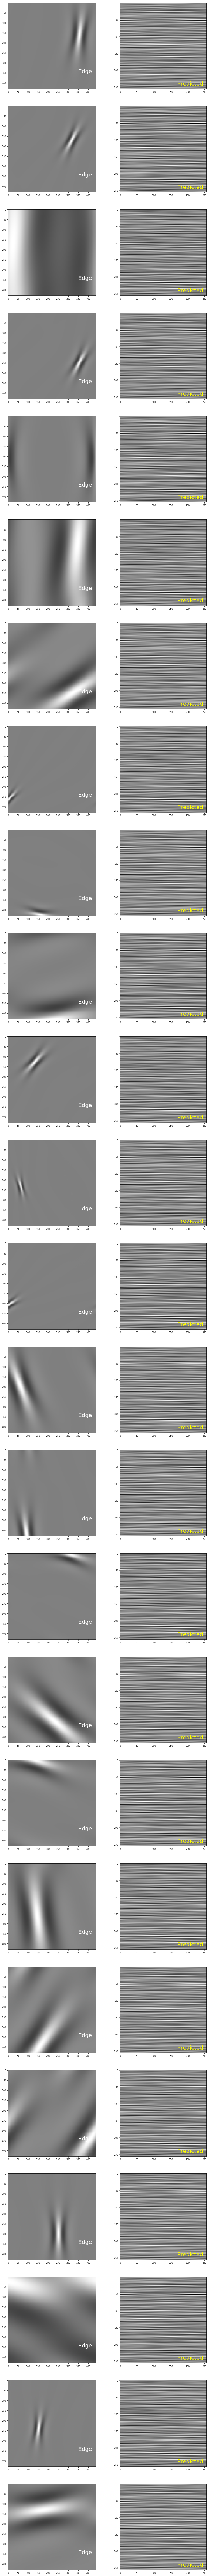

In [44]:
 
import os

subfolders = sorted(os.listdir("16_clouds_easy"))
fig_width = 14
fig, axs = plt.subplots(len(output_list), 2,figsize=(fig_width, fig_width/2*len(output_list)))

for i, tup in enumerate(output_list) :
    
    axs[i,0].imshow(output_list[i][1])
    axs[i, 0].text(350, 420, 'Edge', color='white', fontsize=20) #text indicating edge
    
    #opens a motionCloud to display, from the subfolder of the predicted label (output_list[i][0])
    #and does a secondlistdir to get the first image from that subfolder (it's a bit hairy really)
    MC_to_display = Image.open('./16_clouds_easy/%s/%s' % (subfolders[output_list[i][0]],
                                                          os.listdir("16_clouds_easy/%s" % subfolders[output_list[i][0]])[0]))
    #MC_to_display = np.asarray(MC_to_display)
    axs[i,1].imshow(MC_to_display, cmap= 'gray')
    #fig, axs[i, 1] = mp.imshow((MC_to_display),fig=fig, ax=axs[i, 1], norm=False) #MC
    axs[i, 1].text(170, 245, 'Predicted', color='yellow', fontsize=20) #text indicating edge
    

# Test

tensor([ 6], device='cuda:0')
tensor([ 12], device='cuda:0')
tensor([ 10], device='cuda:0')
tensor([ 10], device='cuda:0')
tensor([ 10], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 6], device='cuda:0')
tensor([ 12], device='cuda:0')
tensor([ 15], device='cuda:0')
tensor([ 12], device='cuda:0')


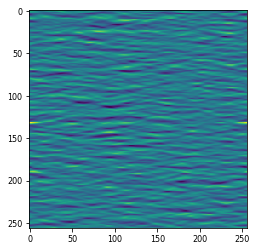

In [41]:
#testing prediction for MCs, seems like a lot of them are predicted as 6 :/
subfolders = sorted(os.listdir("16_clouds_easy_test"))
for i in range(len(subfolders)) :
    imgpredoni = Image.open("16_clouds_easy_test/%s/B0 11.25.png" % subfolders[i])
    plt.imshow(imgpredoni)
    imgpredoni = transformations(imgpredoni)
    imgpredoni = Variable(imgpredoni.view(-1, sequence_length, input_size)).cuda()

    outputs = model(imgpredoni)
    who, predicted = torch.max(outputs.data,1)
    print(predicted)

In [ ]:
#testing whether the labels are correct or aren't
print(test_set.classes)
for x,y in train_loader:
    print(y)